# GRID4EARTH — **NESTED** HEALPix: implicit vs. authalic (WGS84) Comparision notebook


This notebook is made for you to understand what is the effect on your HELAPix data, if you mix HEALPix in Implicit mapping of elipsoide , and Authalic (WGS84)map,

It will introduce the definition of authalic sphere.  It will define implicte and authalic mapping to healpix. 

- The first part you will see the came cell id in implicit and authalic mapping cell centers are apart for how many km
- second part, you will see the same geographic coordinate of lat lon,  if you express it in healpix in implit mapping or authalic mapping, the cell id of healpix would be what, to see how far the cell_id's are appart, together with the distance from cell centers from these cell_id's

on Both case, cell centers are computed in WGS84 represented latitude and longitude  distance 




## Detailed variables & parameters in the authalic conversion

We relate **geodetic (geographic) latitude（緯度）** $\phi$ on WGS84 to the **authalic latitude** $\xi$ on the equal-area sphere:

$$
\sin \xi = \frac{q(\phi)}{Q},
\qquad
Q \equiv q\!\left(\frac{\pi}{2}\right)
$$

where

$$
q(\phi)
=
\frac{(1-e^2)\,\sin\phi}{1 - e^2 \sin^2\phi}
-
\frac{1-e^2}{2e}
\ln\!\left(\frac{1 - e\sin\phi}{1 + e\sin\phi}\right).
$$

These are the standard formulas for the **authalic latitude** (ellipsoid → equal-area sphere transformation), with modern numerical recommendations given by *Karney (2022)*.

## Symbols (with units and WGS84 values)

- **$a$** — semi-major axis [m];  
  **WGS84:** $a = 6\,378\,137.0$

  
- **$b$** — semi-minor axis [m]; $b = a(1 - f)$;  
  **WGS84:** $b \approx 6\,356\,752.314\,245$  
- **$f$** — flattening; $f = (a-b)/a$;  
  **WGS84:** $f = 1/298.257223563 \approx 0.00335281$  
- **$e$** — eccentricity; $e = \sqrt{1 - (b/a)^2}$;  
  **WGS84:** $e \approx 0.0818191908426$, $e^2 \approx 0.00669437999014$  
- **$\phi$** — geodetic (geographic) latitude on the ellipsoid [rad], domain $[-\pi/2,\, \pi/2]$  
- **$\xi$** — authalic latitude on the equal-area sphere [rad], same domain as $\phi$  
- **$q(\phi)$** — dimensionless, strictly increasing in $\phi$ for an oblate ellipsoid  
- **$Q = q(\pi/2)$** — constant depending only on the ellipsoid;  
  **WGS84:** $Q \approx 1.99553$  
- **$R_q$** — authalic radius:  
  $$
  R_q = a \sqrt{\frac{Q}{2}}
  $$
  **WGS84:** $R_q \approx 6\,371\,007.18\ \text{m}$  


## Variables and parameters in the authalic mapping

Authalic mapping relates **geodetic latitude** `φ` on WGS84 to **authalic latitude** `ξ` on an area‑equivalent sphere:

- `a, b, f, e, e²`: WGS84 semi‑major, semi‑minor, flattening, eccentricity, eccentricity²  
- `φ`: geodetic latitude (radians)  
- `ξ`: authalic latitude (radians)  
- `q(φ)`: \(\frac{(1-e^2)\sin\phi}{1-e^2\sin^2\phi} - \frac{1-e^2}{2e}\ln\frac{1-e\sin\phi}{1+e\sin\phi}\)  
- `Q = q(π/2)`  
- Forward: `ξ = asin(q(φ)/Q)`  
- Inverse: solve `q(φ) = Q sin ξ` (Newton with `dq/dφ = 2(1-e²)cosφ/(1-e² sin²φ)²`)


## Forward mapping (ellipsoid → sphere): $\phi \to \xi$

1. Compute $q = q(\phi)$  
2. Compute  
   $$
   \xi = \arcsin\!\left(\frac{q}{Q}\right)
   $$
   (clamp argument to $[-1, 1]$ numerically).

## Inverse mapping (sphere → ellipsoid): $\xi \to \phi$

1. Compute
   $$\text{target} = Q \sin \xi$$  
2. Solve
   $$q(\phi) = \text{target}$$ by 1-D Newton iteration.  
   The derivative is
   
   $$
   \frac{dq}{d\phi}
   =
   \frac{2(1-e^2)\cos\phi}{\bigl(1-e^2\sin^2\phi\bigr)^2}.
   $$
4. Use tolerance $\sim 10^{-14}$ rad.

## Longitudes

Longitude is passed through unchanged:

$$
\lambda_{\text{sphere}} = \lambda_{\text{ellipsoid}}.
$$

So all differences are meridional ($\Delta\text{lat}$) for the same HEALPix pixel index.

## 1. Comparision for the **same cell ID**
Compare positions for the **same NESTED** HEALPix cell (`depth`, `ipix`) under:
- **Implicit** (`φ = ξ`, longitude identity)
- **Authalic/WGS84** via `healpix-geo` (equal-area on WGS84)

Outputs Δlat (deg) and geodesic distance (m) on WGS84.

In [1]:

# Optional installs if missing:
#!pip install --upgrade healpix-geo
#!pip -q install healpix-geo geographiclib #astropy-healpix healpy numpy matplotlib
#!pip install geographiclib

In [2]:
import numpy as np
import healpix_geo.utils as hgu
import healpix_geo.nested as hgn   # <-- also import nested

def _check_ipixels_patched(data, depth):
    """
    Replacement for healpix_geo.utils._check_ipixels
    that avoids integer overflow for large depths.
    """
    # Ensure depth is a plain Python int
    depth = int(depth)

    # Compute npix in Python int space (no overflow)
    npix = 12 * (4 ** depth)

    data = np.asarray(data)

    if (data >= npix).any() or (data < 0).any():
        raise ValueError(
            f"The input HEALPix cells contains value out of [0, {npix - 1}]"
        )

# Patch both modules
hgu._check_ipixels = _check_ipixels_patched
hgn._check_ipixels = _check_ipixels_patched

print("Patched healpix_geo.utils._check_ipixels and healpix_geo.nested._check_ipixels")

import healpix_geo.utils, healpix_geo.nested
print("Same function?",
      healpix_geo.utils._check_ipixels is healpix_geo.nested._check_ipixels)

Patched healpix_geo.utils._check_ipixels and healpix_geo.nested._check_ipixels
Same function? True


In [3]:

import math, numpy as np
_has_hpxgeo = False
try:
    from healpix_geo.nested import healpix_to_lonlat as hpx_to_lonlat_nested
    from healpix_geo.nested import vertices as nested_vertices
    _has_hpxgeo = True
except Exception as e:
    _hpxgeo_import_error = repr(e)
    _has_hpxgeo = False


# Fallbacks (not strictly required if healpix-geo is available)
_has_astropy_healpix = False
_has_healpy = False
if not _has_hpxgeo:
    try:
        from astropy_healpix import HEALPix
        from astropy import units as u
        _has_astropy_healpix = True
    except Exception:
        try:
            import healpy as hp
            _has_healpy = True
        except Exception:
            pass

def geodesic_distance_m(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    try:
        from geographiclib.geodesic import Geodesic
        g = Geodesic.WGS84.Inverse(lat1_deg, lon1_deg, lat2_deg, lon2_deg)
        print('dist, g')
        return float(g['s12'])
    except Exception:
        R = 6371008.8
        rlat1, rlon1 = math.radians(lat1_deg), math.radians(lon1_deg)
        rlat2, rlon2 = math.radians(lat2_deg), math.radians(lon2_deg)
        dlat, dlon = rlat2-rlat1, rlon2-rlon1
        h = math.sin(dlat/2)**2 + math.cos(rlat1)*math.cos(rlat2)*math.sin(dlon/2)**2
        print('toto')
        return 2*R*math.asin(min(1.0, math.sqrt(h)))

def npix_from_depth(depth: int) -> int:
    return 12 * (4**depth)

def sphere_center(depth: int, ipix: int):
    if _has_hpxgeo:
        lon, lat = hpx_to_lonlat_nested(
            np.array([np.uint64(ipix)], dtype='uint64'),
            np.uint8(depth),
            ellipsoid='sphere'
        )
        print('implicite',lon,lat)
        return float(lon[0]), float(lat[0])
    elif _has_astropy_healpix:
        nside = 2**depth
        hpix = HEALPix(nside=nside, order='nested', frame=None)
        lon, lat = hpix.pixel_to_lonlat(ipix)
        return float(lon.to(u.deg)), float(lat.to(u.deg))
    elif _has_healpy:
        nside = 2**depth
        theta, phi = hp.pix2ang(nside, ipix, nest=True)
        lon = math.degrees(phi)
        lat = 90.0 - math.degrees(theta)
        return lon, lat
    else:
        raise ImportError("Need `healpix-geo` (preferred) or `astropy-healpix`/`healpy`.")

def implicit_lonlat(depth: int, ipix: int):
    lon_sph, lat_sph = sphere_center(depth, ipix)
    return lon_sph, lat_sph

# Fallback authalic mapping if WGS84 center isn't available from healpix-geo
a = 6378137.0
f = 1.0/298.257223563
b = a*(1.0 - f)
e2 = 1.0 - (b*b)/(a*a)
e  = math.sqrt(e2)

def _q(phi):
    s = math.sin(phi)
    term1 = (1.0 - e2)*s/(1.0 - e2*s*s)
    arg = (1.0 - e*s)/(1.0 + e*s)
    arg = max(arg, 1e-32)
    term2 = (1.0 - e2)/(2.0*e)*math.log(arg)
    return term1 - term2

Q = _q(math.pi/2)

def _dq_dphi(phi):
    c = math.cos(phi)
    return 2.0*(1.0 - e2)*c/(1.0 - e2*(math.sin(phi)**2))**2

def _phi_from_xi(xi, tol=1e-14, max_iter=20):
    target = math.sin(xi)*Q
    phi = xi
    for _ in range(max_iter):
        step = (_q(phi) - target)/_dq_dphi(phi)
        phi -= step
        if abs(step) < tol:
            break
    return phi

def authalic_lonlat(depth: int, ipix: int):
    if _has_hpxgeo:
        lon, lat = hpx_to_lonlat_nested(
            np.array([np.uint64(ipix)], dtype='uint64'),
            np.uint8(depth),
            ellipsoid='WGS84'
        )
        print('authalic', lon,lat)
        return float(lon[0]), float(lat[0])
    else:
        lon_sph, lat_sph = sphere_center(depth, ipix)
        xi = math.radians(lat_sph)
        phi = _phi_from_xi(xi)
        return lon_sph, math.degrees(phi)

def compare_cell(depth: int, ipix: int):
    lon_imp, lat_imp = implicit_lonlat(depth, ipix)
    lon_auth, lat_auth = authalic_lonlat(depth, ipix)
    dist_m = geodesic_distance_m(lat_imp, lon_imp, lat_auth, lon_auth)
    return {
        "depth": depth,
        "ipix": int(ipix),
        "lon_implicit_deg": lon_imp,
        "lat_implicit_deg": lat_imp,
        "lon_authalic_deg": lon_auth,
        "lat_authalic_deg": lat_auth,
        "delta_lon_deg": (lon_auth - lon_imp + 540.0) % 360.0 - 180.0,
        "delta_lat_deg": lat_auth - lat_imp,
        "distance_m": dist_m,
        "backend": "healpix-geo(nested)" if _has_hpxgeo else ("astropy-healpix(nested)" if _has_astropy_healpix else ("healpy(nest=True)" if _has_healpy else "none"))
    }


In [11]:
depth = 19
npix = npix_from_depth(depth)
ipix = 925141755235

print("depth:", depth)
print("npix_from_depth:", npix)
print("ipix:", ipix)


res = compare_cell(depth, ipix)
res

depth: 19
npix_from_depth: 3298534883328
ipix: 925141755235
implicite [355.49999016] [48.30003599]
authalic [355.49999016] [48.42744494]
dist, g


{'depth': 19,
 'ipix': 925141755235,
 'lon_implicit_deg': 355.4999901550902,
 'lat_implicit_deg': 48.300035985410325,
 'lon_authalic_deg': 355.4999901550902,
 'lat_authalic_deg': 48.427444939273315,
 'delta_lon_deg': 0.0,
 'delta_lat_deg': 0.12740895386298945,
 'distance_m': 14167.5435864553,
 'backend': 'healpix-geo(nested)'}

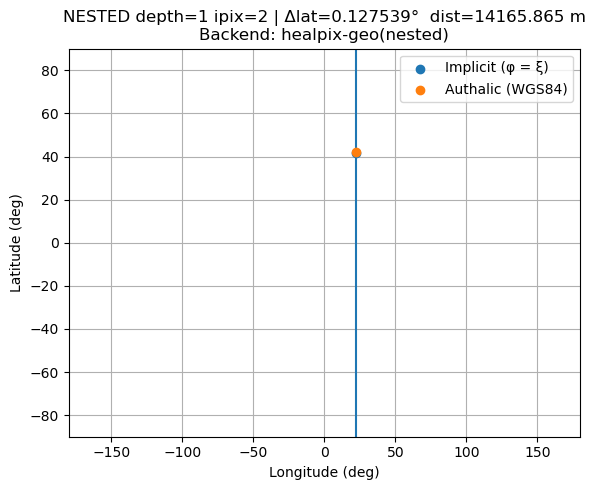

In [5]:

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.plot([res["lon_implicit_deg"], res["lon_implicit_deg"]], [-90, 90])
plt.scatter([res["lon_implicit_deg"]], [res["lat_implicit_deg"]], label="Implicit (φ = ξ)", zorder=3)
plt.scatter([res["lon_authalic_deg"]], [res["lat_authalic_deg"]], label="Authalic (WGS84)", zorder=3)
plt.title(f"NESTED depth={res['depth']} ipix={res['ipix']} | Δlat={res['delta_lat_deg']:.6f}°  dist={res['distance_m']:.3f} m\nBackend: {res['backend']}")
plt.xlabel("Longitude (deg)"); plt.ylabel("Latitude (deg)")
plt.ylim(-90, 90); plt.xlim(-180, 180)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


## 2. 

In [6]:
from healpix_geo.nested import lonlat_to_healpix as nested_lonlat_to_healpix
def locate_and_compare_cell(depth: int, lon_deg: float, lat_deg: float):
    """
    Given geographic lon/lat and a HEALPix depth, find the containing cell
    for both 'sphere' and 'WGS84' ellipsoids, then compare them.
    """
    if not _has_hpxgeo:
        raise ImportError("Need `healpix-geo` to compare sphere vs WGS84 cell ids.")

    # 1. Prepare inputs
    depth_arr = np.uint8(depth)
    lon_arr   = np.array([lon_deg], dtype="float64")
    lat_arr   = np.array([lat_deg], dtype="float64")

    # 2. Get HEALPix ids for sphere and WGS84
    ipix_sphere = nested_lonlat_to_healpix(
        lon_arr, lat_arr, depth_arr, ellipsoid="sphere"
    ).astype("uint64")

    ipix_wgs84 = nested_lonlat_to_healpix(
        lon_arr, lat_arr, depth_arr, ellipsoid="WGS84"
    ).astype("uint64")

    # 3. Get the centers of those cells
    lonc_sph, latc_sph = hpx_to_lonlat_nested(
        ipix_sphere, depth_arr, ellipsoid="sphere"
    )
    lonc_wgs, latc_wgs = hpx_to_lonlat_nested(
        ipix_wgs84, depth_arr, ellipsoid="WGS84"
    )

    lonc_sph, latc_sph = float(lonc_sph[0]), float(latc_sph[0])
    lonc_wgs, latc_wgs = float(lonc_wgs[0]), float(latc_wgs[0])

    # 4. Distance between the two cell centers
    dist_m = geodesic_distance_m(
        latc_sph, lonc_sph,
        latc_wgs, lonc_wgs
    )

    # 5. Build a small summary dict
    return {
        "depth": depth,
        "input_lon_deg": float(lon_deg),
        "input_lat_deg": float(lat_deg),

        "ipix_sphere": int(ipix_sphere[0]),
        "ipix_wgs84": int(ipix_wgs84[0]),
        "cell_id_shift": int(ipix_wgs84[0]) - int(ipix_sphere[0]),

        "center_lon_sphere_deg": lonc_sph,
        "center_lat_sphere_deg": latc_sph,
        "center_lon_wgs84_deg": lonc_wgs,
        "center_lat_wgs84_deg": latc_wgs,

        "center_distance_m": dist_m,
        "same_cell": bool(ipix_sphere[0] == ipix_wgs84[0]),
    }

In [17]:
depth = 19
lon = -4.5   # example: off Brittany 🙂
lat = 48.3

info = locate_and_compare_cell(depth, lon, lat)
info

dist, g


{'depth': 19,
 'input_lon_deg': -4.5,
 'input_lat_deg': 48.3,
 'ipix_sphere': 925141755235,
 'ipix_wgs84': 925139515158,
 'cell_id_shift': -2240077,
 'center_lon_sphere_deg': 355.4999901550902,
 'center_lat_sphere_deg': 48.300035985410325,
 'center_lon_wgs84_deg': 355.49994110256006,
 'center_lat_wgs84_deg': 48.30001550557827,
 'center_distance_m': 4.293065399343361,
 'same_cell': False}